<center> <h1><b>UNIDRO Challenge</b></h1> </center>

This notebook was prepared to present a solution for the [Mine Problem (UNIDRO)](https://quera.ir/contest/assignments/31720/problems) contest as part of the post-webinar held on August 24, 2021. 

It uses the YOLO object detection framework in Python.

For any questions regarding this notebook, you can contact [Quera](https://quera.ir/contact).

First, we need to import the relevant libraries, download the dataset, and have them available in [Google Colab](https://colab.research.google.com).

P.S. It is highly recommended to enable `GPU` on this notebook for a faster computation.

## **Install & import libraries and download datasets**

In [ ]:
%%capture

# Change to the contect directory
%cd /content/

# Remove previous files
%rm -rf *

# Download the dataset
! gdown --id 1fSzUMCJHx3JHwrDpY_Qz6KI1zIUv3BnC
! unzip data.zip
! rm data.zip

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image, ImageOps
import subprocess
import warnings
import random
import shutil
import math
import json
import cv2
import os

from google.colab.patches import cv2_imshow
import pandas as pd
import numpy as np

# Turn off the warnings!
warnings.simplefilter(action='ignore')

# Show plots inside the jupyter notebook
plt.rcParams["figure.figsize"] = (12,16)
%matplotlib inline

## **Set Global Parameters**

In [ ]:
random_seed = 42
validation_ratio = 0.2
resized_image_dim = 406

data_dir = Path("/content")
train_dir = data_dir / "train"

test_rqd_dir = data_dir / "test-rqd"

validation_dir = data_dir / "validation"

label_file = "label.xlsx"
valid_file = "valid.txt"

#**Step 1 - Explore the dataset**


In [ ]:
# Read the labels from the Excel file
labels = pd.read_excel(label_file)

labels.head()

,image_name,label_name,xmin,ymin,width,height,image_width,image_height
0,M3-BH130-1.jpg,wood,2412,1552,152,197,4020,2929
1,M3-BH130-1.jpg,wood,2917,2072,140,220,4020,2929
2,M3-BH130-1.jpg,wood,3820,1567,167,209,4020,2929
3,M3-BH130-1.jpg,wood,3603,2341,201,186,4020,2929
4,M3-BH130-1.jpg,wood,1676,2713,159,171,4020,2929


In [ ]:
def is_image(f):
  """This function gets a file path a checkes whether it is an image or not"""
  if str(f).split(".")[-1].lower() in ["jpg","jpeg"]:
    return True
  else:
    return False

In [ ]:
# Q1:

training_image_paths = list(train_dir.rglob("*.[jJ][pP][gG]")) + list(train_dir.rglob("*.[jJ][pP][eE][gG]"))

print(f'There are {len(training_image_paths)} images in the training set')

There are 156 images in the training set


In [ ]:
# Q2:
unique_boreholes = set()
for path in training_image_paths:
  borehole = str(path).split("/")[-1].split("-")[1]
  unique_boreholes.add(borehole)

print(f'There are {len(unique_boreholes)} boreholes in the training set')

There are 5 boreholes in the training set


In [ ]:
# Q3:

df = pd.read_excel("from-to-rqd.xlsx")
display(df.head())

df["length"] = df["to"] - df["from"]
print(f'\nThere maximum run length is {int(df["length"].max())}')

,RunId,from,to
0,M3-BH3299-1-1,0.0,2.2
1,M3-BH3299-1-2,2.2,3.3
2,M3-BH3299-1-3,3.3,4.4
3,M3-BH3299-2-1,4.4,4.9
4,M3-BH3299-2-2,4.9,6.5



There maximum run length is 3


In [ ]:
# Q4:
max_to = df.to.max()

runId = df[df.to==max_to].RunId.iloc[0]
boreholeId = "-".join(runId.split("-")[:-1])

print(f'The borehole with maximum "To" is {boreholeId}')

The borehole with maximum "To" is M3-BH3301-21


# **Step 2 - Detect Objects**
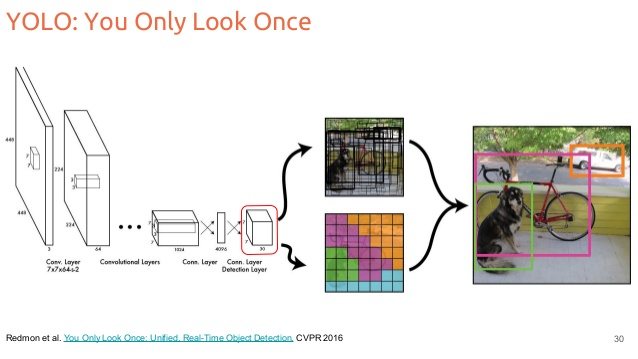


## **Prepare the dataset according to the [YOLO format](https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects)**

In [ ]:
colors = set()

def resize_images(dir):
  """Resize the images in the given path"""
  for image in dir.iterdir():
    # Opens a image in RGB mode
    im = Image.open(image)
    im = im.resize((resized_image_dim,resized_image_dim))
    # Save the image
    im.save(image)
  return

# Resize images into resized_image_dim (default: 416*416) to have faster training & prediciton
resize_images(train_dir)
resize_images(test_rqd_dir)

In [ ]:
def list_folder_images(file, images):
  with open(file, "w") as f:
    for img in images:
      f.write(f"{img}\n")
  return

def create_flipped_image(file_path, new_file_path):
  im = Image.open(file_path)
  im_flip = ImageOps.mirror(im)
  im_flip.save(new_file_path, quality=100, subsampling=0)

In [ ]:
# Select the 20% of the train data as validation
unique_images = labels.image_name.unique()
validation_images = np.random.choice(unique_images,int(len(unique_images)*validation_ratio))

# Save the validation image paths into a file
list_folder_images(valid_file, validation_images)

labels["xmax"] = labels["xmin"] + labels["width"]
labels["ymax"] = labels["ymin"] + labels["height"]

valid_images = Path(valid_file).read_text().split('\n')
validation_dir.mkdir(exist_ok=True)

# Create a dictionary mapping the object class name to its index
obj_class_mapping = {}
for index, item in enumerate(labels.label_name.unique()):
  obj_class_mapping[item] = index

# Adjust the train and validation folders according to the format the YOLO model expects for input data
for name, objs in labels.groupby("image_name"):
  if name in validation_images:
    path = f'{validation_dir / name.split(".")[0]}.txt'
    shutil.move(train_dir/name, validation_dir/name)
  else:
    # Perform data augmentation (mirroring)
    flipped_image_name = name.split(".")[0] + "_flipped." + name.split(".")[-1]
    create_flipped_image(train_dir/name , train_dir/flipped_image_name)
    flipped_path = f'{train_dir / name.split(".")[0]}_flipped.txt'

    with open(flipped_path, "w") as f:
      for _,obj in objs.iterrows():
        line = f'{obj_class_mapping[obj["label_name"]]} {1 - (obj["xmin"]+obj["xmax"])/(2*obj["image_width"])} {(obj["ymin"]+obj["ymax"])/(2*obj["image_height"])} {(obj["xmax"] - obj["xmin"])/obj["image_width"]} {(obj["ymax"] - obj["ymin"])/obj["image_height"]}\n'
        f.write(line)

    path = f'{train_dir / name.split(".")[0]}.txt'

  with open(path, "w") as f:
    for _,obj in objs.iterrows():
      line = f'{obj_class_mapping[obj["label_name"]]} {(obj["xmin"]+obj["xmax"])/(2*obj["image_width"])} {(obj["ymin"]+obj["ymax"])/(2*obj["image_height"])} {(obj["xmax"] - obj["xmin"])/obj["image_width"]} {(obj["ymax"] - obj["ymin"])/obj["image_height"]}\n'
      f.write(line)

# **Train a customized YOLO model on our own dataset**

In [ ]:
# Check whether GPU is provided
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [ ]:
# This cell ensures you have the correct architecture for your respective GPU
os.environ['GPU_TYPE'] = str(os.popen('nvidia-smi --query-gpu=name --format=csv,noheader').read())

def getGPUArch(argument):
  try:
    argument = argument.strip()
    # All Colab GPUs
    archTypes = {
        "Tesla V100-SXM2-16GB": "-gencode arch=compute_70,code=[sm_70,compute_70]",
        "Tesla K80": "-gencode arch=compute_37,code=sm_37",
        "Tesla T4": "-gencode arch=compute_75,code=[sm_75,compute_75]",
        "Tesla P40": "-gencode arch=compute_61,code=sm_61",
        "Tesla P4": "-gencode arch=compute_61,code=sm_61",
        "Tesla P100-PCIE-16GB": "-gencode arch=compute_60,code=sm_60"

      }
    return archTypes[argument]
  except KeyError:
    return "GPU must be added to GPU Commands"
os.environ['ARCH_VALUE'] = getGPUArch(os.environ['GPU_TYPE'])

print("GPU Type: " + os.environ['GPU_TYPE'])
print("ARCH Value: " + os.environ['ARCH_VALUE'])

GPU Type: Tesla T4

ARCH Value: -gencode arch=compute_75,code=[sm_75,compute_75]


In [ ]:
%%capture

# Download the Yolo code
# We clone the fork of darknet maintained by roboflow
# Small changes have been made to configure darknet for training
! git clone https://github.com/roboflow-ai/darknet.git

# Install environment from the Makefile
%cd /content/darknet/

! sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
! sed -i 's/GPU=0/GPU=1/g' Makefile
! sed -i 's/CUDNN=0/CUDNN=1/g' Makefile
! sed -i "s/ARCH= -gencode arch=compute_60,code=sm_60/ARCH= ${ARCH_VALUE}/g" Makefile
! make

# Download the newly released yolov4-tiny weights
! wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights
! wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29

In [ ]:
# Set up training file directories for custom dataset
%mkdir data/obj

# Copy image and labels
%cp /content/train/* data/obj/
%cp /content/validation/* data/obj/

num_classes = 2

sorted_mapping = {v: k for k, v in sorted(obj_class_mapping.items(), key=lambda item: item[1])}

with open('data/obj.names', 'w') as out:
  for index in range(len(sorted_mapping)):
    out.write(f"{sorted_mapping[index]}\n")

with open('data/obj.data', 'w') as out:
  out.write(f'classes = {num_classes}\n')
  out.write('train = data/train.txt\n')
  out.write('valid = data/valid.txt\n')
  out.write('names = data/obj.names\n')
  out.write('backup = backup/')

# Write train file (just the image list)
with open('data/train.txt', 'w') as out:
  for img in [f for f in os.listdir(train_dir) if is_image(f)]:
    out.write('data/obj/' + img + '\n')

# Write the valid file (just the image list)
with open('data/valid.txt', 'w') as out:
  for img in [f for f in os.listdir(validation_dir) if is_image(f)]:
    out.write('data/obj/' + img + '\n')

In [ ]:
# We build config dynamically based on number of classes
# We build iteratively from base config files. This is the same file shape as cfg/yolo-obj.cfg

max_batches = num_classes*2000
steps1 = .8 * max_batches
steps2 = .9 * max_batches
steps_str = str(steps1)+','+str(steps2)
num_filters = (num_classes + 5) * 3

print("writing config for a custom YOLOv4 detector detecting number of classes: " + str(num_classes))

# Instructions from the darknet repo
# Change line max_batches to (classes*2000 but not less than number of training images, and not less than 6000), f.e. max_batches=6000 if you train for 3 classes
# Change line steps to 80% and 90% of max_batches, f.e. steps=4800,5400

if os.path.exists('./cfg/custom-yolov4-tiny-detector.cfg'): os.remove('./cfg/custom-yolov4-tiny-detector.cfg')

# Customize iPython writefile so we can write variables

from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

writing config for a custom YOLOv4 detector detecting number of classes: 2


Check the following links for the parameters:

*   https://githubmemory.com/repo/roboflow-ai/darknet
*   https://github.com/AlexeyAB/darknet/wiki/CFG-Parameters-in-the-%5Bnet%5D-section

In [ ]:
%%writetemplate ./cfg/custom-yolov4-tiny-detector.cfg
[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=64
subdivisions=24
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.00261
burn_in=1000
max_batches = {max_batches}
policy=steps
steps={steps_str}
scales=.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

##################################

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters={num_filters}
activation=linear



[yolo]
mask = 3,4,5
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes={num_classes}
num=6
jitter=.3
scale_x_y = 1.05
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
ignore_thresh = .7
truth_thresh = 1
random=1
nms_kind=greedynms
beta_nms=0.6

[route]
layers = -4

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[upsample]
stride=2

[route]
layers = -1, 23

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters={num_filters}
activation=linear

[yolo]
mask = 1,2,3
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes={num_classes}
num=6
jitter=.3
scale_x_y = 1.05
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
ignore_thresh = .7
truth_thresh = 1
random=0
nms_kind=greedynms
beta_nms=0.6

In [ ]:
!./darknet detector train data/obj.data cfg/custom-yolov4-tiny-detector.cfg yolov4-tiny.conv.29 -dont_show -map

# If you get CUDA out of memory adjust subdivisions above!
# Adjust max batches down for shorter training above

Streaming output truncated to the last 5000 lines.
 3037: 0.778663, 0.665186 avg loss, 0.002610 rate, 0.656342 seconds, 145776 images, 0.187168 hours left
Loaded: 0.000046 seconds

 (next mAP calculation at 3100 iterations) 
 Last accuracy mAP@0.5 = 79.17 %, best = 82.25 % 
 3038: 0.621814, 0.660849 avg loss, 0.002610 rate, 0.627802 seconds, 145824 images, 0.187052 hours left
Loaded: 0.000049 seconds

 (next mAP calculation at 3100 iterations) 
 Last accuracy mAP@0.5 = 79.17 %, best = 82.25 % 
 3039: 0.655921, 0.660356 avg loss, 0.002610 rate, 0.640506 seconds, 145872 images, 0.186859 hours left
Loaded: 0.000054 seconds

 (next mAP calculation at 3100 iterations) 
 Last accuracy mAP@0.5 = 79.17 %, best = 82.25 % 
 3040: 0.637238, 0.658044 avg loss, 0.002610 rate, 0.648381 seconds, 145920 images, 0.186700 hours left
Loaded: 0.000043 seconds

 (next mAP calculation at 3100 iterations) 
 Last accuracy mAP@0.5 = 79.17 %, best = 82.25 % 
 3041: 0.768056, 0.669045 avg loss, 0.002610 rate, 0.

In [ ]:
# List all trained weight files

! ls backup

In [ ]:
# list the object classes
! cat data/obj.names

In [ ]:
%%capture
%cd /content/darknet

# Calculate the bounding boxes of all detected objects in the validation, test-rqd, and test-ft folders

test_rqd_file = "/content/test-rqd.txt"
test_ft_file = "/content/test-ft.txt"

list_folder_images(test_rqd_file, [str(path) for path in list(test_rqd_dir.iterdir())])

! ./darknet detector test data/obj.data cfg/custom-yolov4-tiny-detector.cfg backup/custom-yolov4-tiny-detector_best.weights -ext_output -dont_show -out /content/result_valid.json < data/valid.txt
! ./darknet detector test data/obj.data cfg/custom-yolov4-tiny-detector.cfg backup/custom-yolov4-tiny-detector_best.weights -ext_output -dont_show -out /content/result_test_rqd.json < /content/test-rqd.txt

In [ ]:
# Plot the training result after 2000 epochs

fig = plt.figure(figsize=(10,10))
train_result = plt.imread("chart.png")
plt.axis(False)
plt.imshow(train_result);

# **Predict on the validation set**

In [ ]:
# Change directory to home (/content) after finishing the obejct detection training process
%cd /content

In [ ]:
def json_to_csv(input_json, output_csv):
  """Convert json results to CSV considering the confidence threshould to be at least 0.5"""
  
  with open(input_json) as json_file:
    results = json.load(json_file)
  
  instances_list = []
  for image in results:
    for obj in image['objects']:
      instance = {}
      instance["filename"] = image["filename"]
      instance["class"] = obj["name"]
      coords = obj["relative_coordinates"]
      instance["center_x"] = coords["center_x"]
      instance["center_y"] = coords["center_y"]
      instance["width"] = coords["width"]
      instance["height"] = coords["height"]
      instances_list.append(instance)
  instances_df = pd.DataFrame(instances_list)
  instances_df.to_csv(output_csv, index=False)

json_to_csv("result_valid.json","result_valid.csv")
json_to_csv("result_test_rqd.json","result_test_rqd.csv")
# json_to_csv("result_test_ft.json","result_test_ft.csv")

In [ ]:
def draw_bboxes(image, category, center_x, center_y, width, height):
  """Draw an object on an input image each time it is called per object"""
  if category == "number":
    color = (255, 0, 0)
  elif category == "wood":
    color = (0, 0, 255)
  elif category == "+10cm rock":
    color = (255, 255, 255)
  xmin = int((center_x-(width/2))*image_width)
  ymin = int((center_y-(height/2))*image_height)
  xmax = int((center_x+(width/2))*image_width)
  ymax = int((center_y+(height/2))*image_height)
  cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)
  return image

def show_image(image):
  """Show the input image"""
  fig, ax = plt.subplots()
  fig.set_size_inches(18, 10)
  ax.axis("off")
  ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
# Select a random validation image

for i in range(1, 4):
  random_valid_img_path = random.choice([path for path in Path(valid_file).read_text().split('\n')])
  print(f"Random image {i} is : {random_valid_img_path}")

  result_valid_df = pd.read_csv("result_valid.csv")

  image = None

  for _, instance in result_valid_df.iterrows():
    if instance['filename'].split("/")[-1] == random_valid_img_path:
      if isinstance(image, type(None)):
        image = cv2.imread("/content/darknet/"+instance['filename'])
        image_height, image_width = image.shape[:2]
      image = draw_bboxes(image, instance["class"], instance["center_x"], instance["center_y"], instance["width"], instance["height"])
  show_image(image)

# **Step 2 - Calculate the RQD per RunId**

In [ ]:
ft_rqd_df= pd.read_excel("from-to-rqd.xlsx")
ft_rqd_df.head()

In [ ]:
ft_rqd_df.shape

In [ ]:
objects_rqd_df = pd.read_csv("result_test_rqd.csv")
objects_rqd_df["boreholeId"] = objects_rqd_df["filename"].apply(lambda filename: "-".join(filename.split("/")[-1].split(".")[0].split("-")[:-1]))
objects_rqd_df["boxNumber"] = objects_rqd_df["filename"].apply(lambda filename: int(filename.split("/")[-1].split(".")[0].split("-")[-1]))
objects_rqd_df.head()

In [ ]:
borehole_quality_list = []

for boreholeId in objects_rqd_df.boreholeId.unique():
  borehole = objects_rqd_df[objects_rqd_df.boreholeId==boreholeId]
  boxNumbers = borehole.boxNumber.unique()

  RunId_base = boreholeId
  for boxNumber in range(min(boxNumbers), max(boxNumbers)+1):
    count = 1
    box = borehole[borehole.boxNumber==boxNumber]
    rocks = box[box["class"]=="+10cm rock"]
    rocks["is_checked"] = False

    rocks["xmin"] = rocks["center_x"] - rocks["width"]/2
    rocks["xmax"] = rocks["center_x"] + rocks["width"]/2

    rocks["ymin"] = rocks["center_y"] - rocks["height"]/2
    rocks["ymax"] = rocks["center_y"] + rocks["height"]/2
    
    woods = box[box["class"]=="wood"]
    woods.sort_values(by=["center_y"], inplace=True)

    for _, wood in woods.iterrows():
      wood_center_x = wood["center_x"]
      wood_center_y = wood["center_y"]

      rocks_length = 0
      condition = ((wood_center_y > rocks.ymax)|((rocks.ymax>=wood_center_y)&(wood_center_y>=rocks.ymin)&(rocks.center_x<wood_center_x))) & (rocks.is_checked==False)
      selected_rocks = rocks[condition]
      
      for _, rock in selected_rocks.iterrows():
        rock_width = rock["width"]
        if rock_width >= 0.1:
          rocks_length += rock_width
      
      rocks.loc[condition, 'is_checked'] = True

      borehole_quality = {}
      borehole_quality["RunId"] = f"{RunId_base}-{boxNumber}-{count}"
      borehole_quality["rocks_length"] = rocks_length
      count+=1
      borehole_quality_list.append(borehole_quality)
    
    # Check for the last Run
    last_run_condition = (rocks.is_checked==False)
    last_rocks = rocks[last_run_condition]
    
    for _, rock in last_rocks.iterrows():
      rock_width = rock["width"] * 1.1
      if rock_width >= 0.1:
        rocks_length += rock_width
      
    rocks.loc[last_run_condition, 'is_checked'] = True
    borehole_quality = {}
    borehole_quality["RunId"] = f"{RunId_base}-{boxNumber}-{count}"
    borehole_quality["rocks_length"] = rocks_length
    borehole_quality_list.append(borehole_quality)

borehole_quality_df = pd.DataFrame(borehole_quality_list)
borehole_quality_df.head()

In [ ]:
borehole_quality_df.shape

In [ ]:
set(ft_rqd_df.RunId.unique()) - set(borehole_quality_df.RunId.unique())

In [ ]:
set(borehole_quality_df.RunId.unique()) - set(ft_rqd_df.RunId.unique())

In [ ]:
def calc_rqd_group(row):
  rqd = (100*row["rocks_length"] / row["length"])
  if rqd >=0 and rqd <=25:
    return '1'
  elif rqd >25 and rqd <=50:
    return '2'
  elif rqd > 50 and rqd <=75:
    return '3'
  elif rqd > 75 and rqd <=90:
    return '4'
  else:
    return '5'

rqd_df = ft_rqd_df.merge(borehole_quality_df, on="RunId", how="inner")
rqd_df["length"] = rqd_df["to"] - rqd_df["from"]
rqd_df["Prediction"] = rqd_df.apply(lambda row: calc_rqd_group(row), axis=1)

results = rqd_df[["RunId","Prediction"]]
results.to_csv("rqd_results.csv", index=False)
results.head()

In [ ]:
result_test_rqd_df = pd.read_csv("result_test_rqd.csv")

for img_path in result_test_rqd_df.filename.unique():
  image = None
  for _, instance in result_test_rqd_df.iterrows():
    if instance['filename'] == img_path:
      if isinstance(image, type(None)):
        image = cv2.imread(instance['filename'])
        image_height, image_width = image.shape[:2]
      image = draw_bboxes(image, instance["class"], instance["center_x"], instance["center_y"], instance["width"], instance["height"])
  show_image(image)